<DIV ALIGN=CENTER>

# Introduction to Bayesian A/B testing
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In this IPython Notebook, we build on 

-----



In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

-----

### Model

-----

In [2]:
# Some common definitions
n_samples = 5000
n_burn = n_samples / 2

# We define a simple function to fit.

np.random.seed(23)

# A non-linear equation
def theModel(x, params = None):

    # Default values
    beta = 0.5
    alpha = 0.25

    if params:
        alpha = params['Intercept']
        beta = params['Slope']

    return (alpha + beta * x)

# Add random noise to model
def randomizeModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1
    
    x = np.linspace(xmin, xmax, num)   
    y = theModel(x) + sigma * np.random.randn(len(x))

    return(x, y)

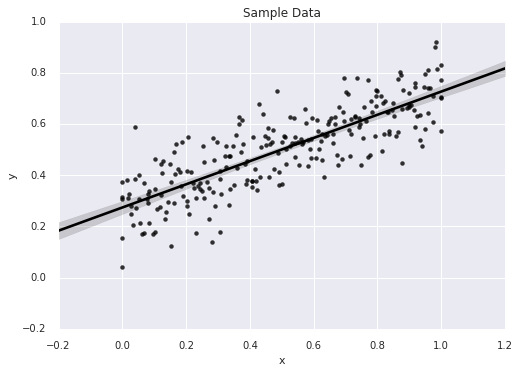

In [3]:
n_bins = 5
n_pts = [25, 40, 50, 60, 75]

# Obtain sample data and plot data and model fit

x = [] ; y = [] ; b = []

for bin in range(n_bins):
    x_i, y_i = randomizeModel(num = n_pts[bin])
    b_i = [bin] * n_pts[bin]
    
    x.extend(x_i)
    y.extend(y_i)
    b.extend(b_i)

df = pd.DataFrame({'x': x, 'y': y, 'b': b})

ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=True, color='black', label="Data")
ax.set(title='Sample Data')
sns.despine(offset=5, trim=True)

-----
### unpooled, non-hierarchical model

-----

In [4]:
# This example follow the example in the pymc3 documentation
# http://pymc-devs.github.io/pymc3/GLM-hierarchical/
import pymc3 as pm

indiv_traces = {}

for bin in range(n_bins):

    # Select subset of data belonging to county
    b_df = df.ix[df.b == bin]
    b_x = b_df.x
    b_y = b_df.y
    
    print('\n\nComputing Posterior for bin {0}'.format(bin))

    with pm.Model() as bin_model:
    
        # First, define stochastic model variables
        intercept = pm.Uniform('Intercept', lower = 0, upper = 1)
        slope = pm.Normal('Slope', mu = 1.0, sd = 1.0)
        
        # Now define stochastic variable for observation errors.    
        sigma = pm.Normal('sigma', mu = 1., sd = 2.0)

        # Expected values using original indepedent variables
        # Deterministic Variable
        b_y_exp =  intercept + slope * b_x

        # Sample values (likelihood)
        likelihood = pm.Normal('yn', mu=b_y_exp, sd=sigma, observed=b_y)
    
        start = pm.find_MAP()
        step = pm.NUTS(scaling=start)
        trace = pm.sample(n_samples, step=step, start=start)
    
    # keep trace for later analysis
    indiv_traces[bin] = trace



Computing Posterior for bin 0
Applied interval-transform to Intercept and added transformed Intercept_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 3.5 sec

Computing Posterior for bin 1
Applied interval-transform to Intercept and added transformed Intercept_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 3.2 sec

Computing Posterior for bin 2
Applied interval-transform to Intercept and added transformed Intercept_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 3.2 sec

Computing Posterior for bin 3
Applied interval-transform to Intercept and added transformed Intercept_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 3.4 sec

Computing Posterior for bin 4
Applied interval-transform to Intercept and added transformed Intercept_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 6.2 sec

-----

## Hierarchical Model

-----

In [5]:
b_idx = df['b'].values

with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    low_i = pm.Normal('low_i', mu=0.0, sd=0.25**2)
    high_i = pm.Normal('high_i', mu=1.0, sd=0.25**2)
    
    mu_i = pm.Normal('mu_i', mu=0.0, sd=0.25**2)
    sigma_i = pm.Uniform('sigma_i', lower=0.0, upper=1.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).

    intercept = pm.Uniform('Intercept', lower = low_i, upper = high_i, shape=n_bins)
    slope = pm.Normal('Slope', mu = mu_i, sd = sigma_i, shape=n_bins)

    # Now define stochastic variable for observation errors.    
    sigma = pm.Normal('Sigma', mu = 1., sd = 2.0)

    # Expected values using original indepedent variables
    # Deterministic Variable
    y_exp =  intercept[b_idx] + slope[b_idx] * df.x

    # Sample values (likelihood)
    likelihood = pm.Normal('yn', mu=y_exp, sd=sigma, observed=df.y)

Applied interval-transform to sigma_i and added transformed sigma_i_interval to model.
Applied interval-transform to Intercept and added transformed Intercept_interval to model.


In [6]:
with hierarchical_model:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    hierarchical_trace = pm.sample(n_samples, step, start=start, progressbar=True)

 [-----------------100%-----------------] 5000 of 5000 complete in 41.6 sec

-----

### Analyze Hierchical Results

-----

In [7]:
print(pm.summary(hierarchical_trace[-n_burn:], \
             varnames=['Slope', 'Intercept', 'Sigma', 'low_i', 'high_i', 'mu_i', 'sigma_i']))


Slope:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.508            0.066            0.001            [0.376, 0.633]
  0.466            0.054            0.001            [0.366, 0.565]
  0.355            0.048            0.001            [0.265, 0.447]
  0.460            0.046            0.001            [0.370, 0.548]
  0.474            0.040            0.001            [0.395, 0.552]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.377          0.464          0.508          0.551          0.635
  0.367          0.429          0.464          0.502          0.568
  0.267          0.323          0.354          0.387          0.449
  0.367          0.430          0.460          0.492          0.546
  0.392          0.448          0.474          0.500          0.551


Intercep

-----

### Analyze Hierchical Results

-----

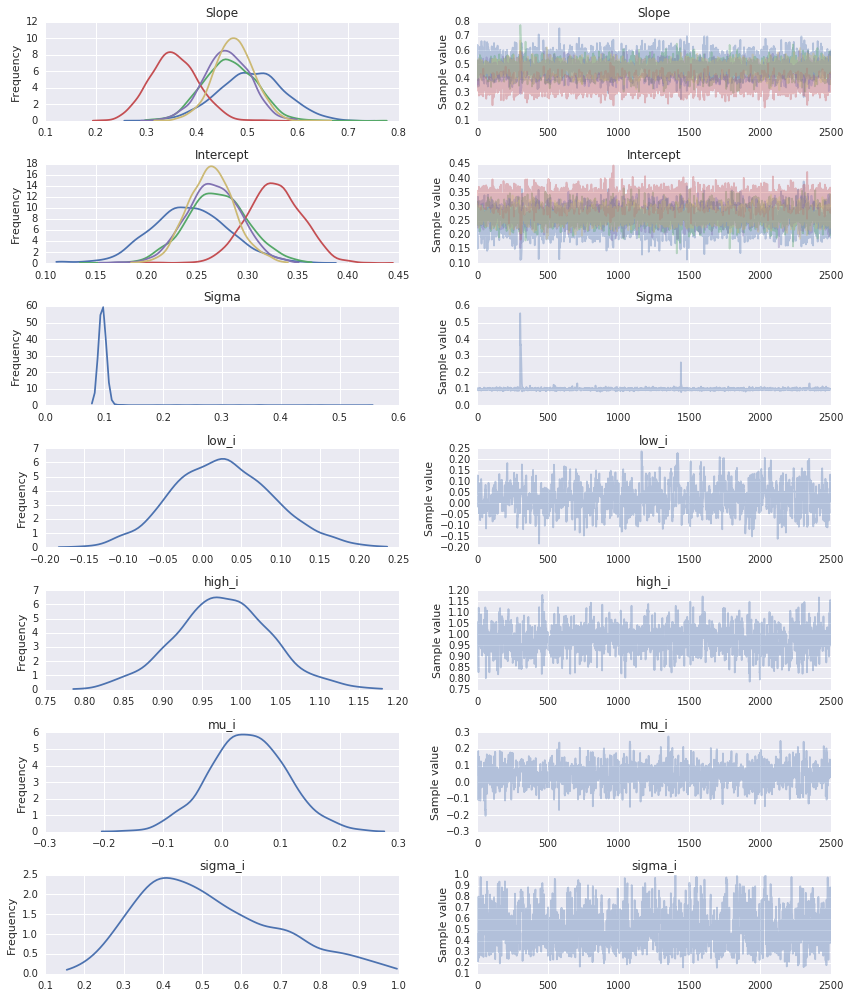

In [8]:
sns.set_style('darkgrid')
pm.traceplot(hierarchical_trace[-n_burn:], \
             varnames=['Slope', 'Intercept', 'Sigma', 'low_i', 'high_i', 'mu_i', 'sigma_i'])
plt.show()

-----

## Compare Regression Methods

Unpooled versus pooled.

-----

In [9]:
def makePlot(df, i_traces, h_traces, c_bin):
    # Set up plot
    sns.set(font_scale=1.0)

    # Grab the bin data
    c_trace = i_traces[c_bin]

    # plot the data for current bin
    ax = sns.regplot(data = df.ix[df.b == c_bin], x = 'x', y = 'y', \
                     fit_reg=False, color='black', label="Data")

    # Compute and plot the true relationship
    x_sample = np.linspace(-0.1, 1.1, 100)
    y_sample = theModel(x_sample)
    plt.plot(x_sample, y_sample, color='r', lw=3, alpha = 0.75, \
             label='True Regression')

    # Define the mean, hiearchical posterior parameters for current bin
    params = {}
    params['Intercept'] = np.mean(h_traces['Intercept'][-n_burn:, c_bin]) 
    params['Slope'] = np.mean(h_traces['Slope'][-n_burn:, c_bin])

    # Compute and plot the mean, hiearchical posterior prediction
    y_est = theModel(x_sample, params)
    plt.plot(x_sample, y_est, color='b', lw=3, alpha = 0.75, \
             label='Hiearchical Posterior Regression')

    # Define the mean, unpooled posterior parameters for the current bin
    params = {}
    params['Intercept'] = np.mean(c_trace['Intercept'][-n_burn:]) 
    params['Slope'] = np.mean(c_trace['Slope'][-n_burn:])

    # Compute and plot the mean, unpooled posterior prediction
    y_est = theModel(x_sample, params)
    plt.plot(x_sample, y_est, color='g', lw=3, alpha = 0.75, \
             label='Unpooled Posterior Regression')
    
    # Decorate plot
    plt.title('Bin {0} Posterior Predictions'.format(c_bin))
    lgnd = plt.legend(loc='upper left')

    for lg in lgnd.legendHandles:
        lg.set_linewidth(2.0)
        
    plt.xlabel('x')
    plt.ylabel('y')

    sns.despine(offset=5, trim=True)
    sns.set(font_scale=1)

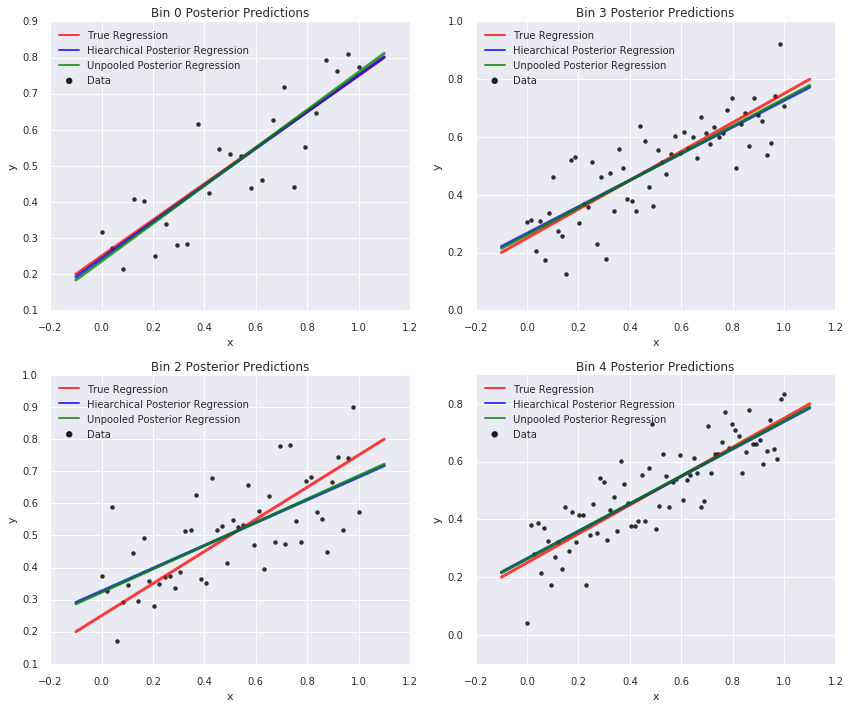

In [10]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
makePlot(df, indiv_traces, hierarchical_trace, 0)

plt.subplot(2, 2, 3)
makePlot(df, indiv_traces, hierarchical_trace, 2)

plt.subplot(2, 2, 2)
makePlot(df, indiv_traces, hierarchical_trace, 3)

plt.subplot(2, 2, 4)
makePlot(df, indiv_traces, hierarchical_trace, 4)

plt.tight_layout()

-----

### Hierchical Modelling Effects

Look at shirnkage plot

-----

In [11]:
# Make Shrinkage Plot

# Compute mean quantities for plot
hier_i = hierarchical_trace['Intercept'][-n_burn:].mean(axis=0)
hier_s = hierarchical_trace['Slope'][-n_burn:].mean(axis=0)
indv_i = [indiv_traces[b]['Intercept'][-n_burn:].mean() for b in range(n_bins)]
indv_s = [indiv_traces[b]['Slope'][-n_burn:].mean() for b in range(n_bins)]

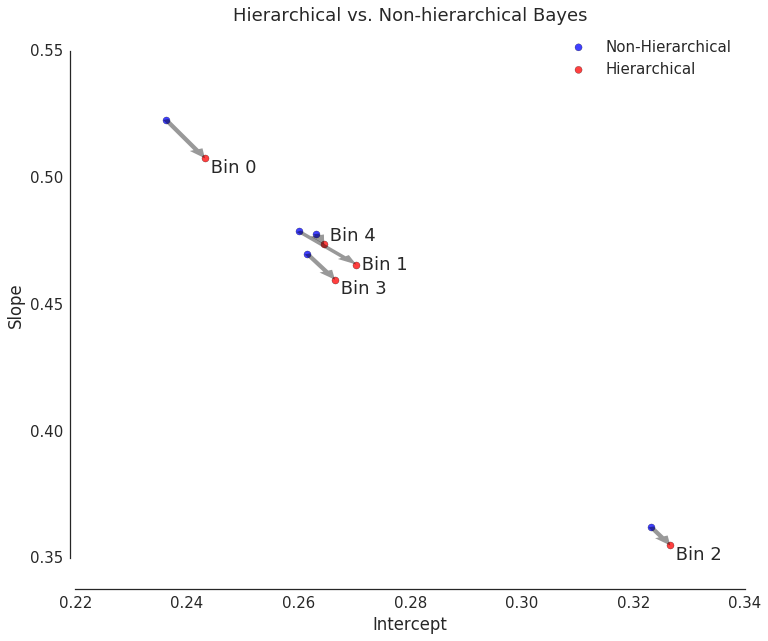

In [12]:
fig = plt.figure(figsize=(12, 10))
sns.set(font_scale=1.5)
sns.set_style('white')

plt.scatter(indv_i, indv_s, c='b', s=50, alpha=0.75, label = 'Non-Hierarchical')
plt.scatter(hier_i, hier_s, c='r', s=50, alpha=0.75, label = 'Hierarchical')

vlocs = ['top', 'center', 'top', 'top', 'bottom']
for i in range(len(indv_s)):  
    plt.arrow(indv_i[i], indv_s[i], hier_i[i] - indv_i[i], hier_s[i] - indv_s[i], \
              fc="k", ec="k", length_includes_head=True, \
              alpha=0.4, head_width=.0025, lw =0.001)
    plt.text(hier_i[i], hier_s[i], ' Bin {0}'.format(i), \
             size = 18, ha='left', va=vlocs[i])

    plt.title('Hierarchical vs. Non-hierarchical Bayes')
lgnd = plt.legend(loc=0)

plt.xlabel('Intercept')
plt.ylabel('Slope')

plt.xlim(0.22, 0.34)
plt.ylim(0.34, 0.56)

sns.despine(offset=5, trim=True)
sns.set(font_scale=1)
plt.show()

-----

### Student Activity

In the preceding cells, we introduced several basic graph concepts,
including XX YY ZZ. Now
that you have run the Notebook, go back and make the following changes
to see how the results change.

1. Change 
2. Replace 
3. Try using 

-----